In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl

Aqui vamos definir algumas constantes que não serão modificadas em nenhum momento. Estão definidos: o tamanho do conjunto de teste e de validação, semente aleatória fixada e número de épocas. 

In [3]:
TAMANHO_TESTE = 0.1
TAMANHO_VALIDACAO = 0.1

SEMENTE_ALEATORIA = 14042003

NUM_EPOCAS = 100

Vamos começar importando os dados.

In [4]:
dados = pickle.load(open('df_teste', 'rb'))

Na célula abaixo definimos a classe DataModule, que herda da classe nativa do PyTorch Lightning (LightningDataModule). É nesse ambiente que vamos preparar os dados que serão passados através da rede neural. Aqui vamos dividir os conjuntos de treino, teste e validação, aplicar normalizadores nos dados de treino e outras operações importantes. 

### DataModule

In [9]:
class DataModule(pl.LightningDataModule):
    def __init__(
        self,
        batch_size = 64,
        num_workers = 4,
    ):
        super().__init__()

        self.batch_size = batch_size
        self.num_workers = num_workers


    def setup(self, stage):
       
        features = list(dados.columns)[1:]
        target = ["Trg"]

        df = dados

        df = df.reindex(features + target, axis=1)

        indices = df.index
        indices_treino_val, indices_teste = train_test_split(
            indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA
        )

        df_treino_val = df.loc[indices_treino_val]
        df_teste = df.loc[indices_teste]

        indices = df_treino_val.index
        indices_treino, indices_val = train_test_split(
            indices,
            test_size=TAMANHO_TESTE,
            random_state=SEMENTE_ALEATORIA,
        )

        df_treino = df.loc[indices_treino]
        df_val = df.loc[indices_val]

        X_treino = df_treino.reindex(features, axis=1).values
        y_treino = df_treino.reindex(target, axis=1).values

        self.x_scaler = MaxAbsScaler()
        self.x_scaler.fit(X_treino)

        self.y_scaler = MaxAbsScaler()
        self.y_scaler.fit(y_treino)

        if stage == "fit":
            X_val = df_val.reindex(features, axis=1).values
            y_val = df_val.reindex(target, axis=1).values

            X_treino = self.x_scaler.transform(X_treino)
            y_treino = self.y_scaler.transform(y_treino)

            X_val = self.x_scaler.transform(X_val)
            y_val = self.y_scaler.transform(y_val)

            self.X_treino = torch.tensor(X_treino, dtype=torch.float32)
            self.y_treino = torch.tensor(y_treino, dtype=torch.float32)

            self.X_val = torch.tensor(X_val, dtype=torch.float32)
            self.y_val = torch.tensor(y_val, dtype=torch.float32)

        if stage == "test":
            X_teste = df_teste.reindex(features, axis=1).values
            y_teste = df_teste.reindex(target, axis=1).values

            X_teste = self.x_scaler.transform(X_teste)
            y_teste = self.y_scaler.transform(y_teste)

            self.X_teste = torch.tensor(X_teste, dtype=torch.float32)
            self.y_teste = torch.tensor(y_teste, dtype=torch.float32)

    def train_dataloader(self):
        return DataLoader(
            TensorDataset(self.X_treino, self.y_treino),
            batch_size=self.batch_size,
            num_workers=self.num_workers,
        )

    def val_dataloader(self):
        return DataLoader(
            TensorDataset(self.X_val, self.y_val),
            batch_size=self.batch_size,
            num_workers=self.num_workers,
        )

    def test_dataloader(self):
        return DataLoader(
            TensorDataset(self.X_teste, self.y_teste),
            batch_size=self.batch_size,
            num_workers=self.num_workers,
        )

A próxima classe que precisamos definir, será chamada de MLP (Multi Layer Perceptron). Essa classe vai criar nossa rede neural utilizando como base a arquitetura que definirmos. É aqui que criamos as camadas com seus respectivos neurônios, definimos as funções de ativação e realizamos: o forward pass, o cálculo de perda, zeramos os gradientes, realizamos o backpropagation e atualizamos os pesos e vieses. Todas essas etapas estão configuradas nessa classe. 

Um ponto importante a se destacar é o otimizador que utilizamos. O otimizador Adam foi empregado aqui. O PyTorch Lightning permite que ele seja facilmente implementado. O Adam combina estratégias para, com base nos gradientes locais, atualizar pesos e viéses de maneira a reduzir a perda e fazer nossa rede convergir. 

### MLP

In [10]:
class MLP(pl.LightningModule):
    def __init__(
        self, num_dados_entrada, num_camadas, num_neuronios, ativacao, taxa_dropout, num_targets, lr
    ):
        super().__init__()

        self.lr = lr
        
        camadas =[]
        
        for _ in range(num_camadas):
            
            camadas.append(nn.Linear(num_dados_entrada, num_neuronios))
            camadas.append(ativacao)
            camadas.append(nn.Dropout(taxa_dropout))
            num_dados_entrada = num_neuronios
            
        camadas.append(nn.Linear(num_neuronios, num_targets))
            
        self.camadas = nn.Sequential(*camadas)

        self.fun_perda = F.l1_loss

        self.perdas_treino = []
        self.perdas_val = []

        self.curva_aprendizado_treino = []
        self.curva_aprendizado_val = []

    def forward(self, x):
        x = self.camadas(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("loss", loss, prog_bar=True)
        self.perdas_treino.append(loss)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("val_loss", loss, prog_bar=True)
        self.perdas_val.append(loss)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("test_loss", loss)

        return loss

    def on_train_epoch_end(self):
        # Atualiza curva de aprendizado
        perda_media = torch.stack(self.perdas_treino).mean()
        self.curva_aprendizado_treino.append(float(perda_media))
        self.perdas_treino.clear()

    def on_validation_epoch_end(self):
        # Atualiza curva de aprendizado
        perda_media = torch.stack(self.perdas_val).mean()
        self.curva_aprendizado_val.append(float(perda_media))
        self.perdas_val.clear()

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr = self.lr)
        return optimizer

O próximo passo será criar um treinador. O PyTorch Lightning tem esse método otimizado e de fácil implementação que controla o processo de treinamento da rede, é para ele que passamos a informação de quantas épocas queremos treinar nossa rede. 

### Treinador

In [11]:
treinador = pl.Trainer(max_epochs=NUM_EPOCAS)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Agora vamos precisar dos nossos dados para treinar a rede, e vamos usar o método .fit do treinador para isso, esse método recebe dois argumentos: as instâncias das duas classes que definimos acima.


### Instância DataModule

O primeiro elemento que vamos criar para o treinador.fit é a instância da classe DataModule:

In [12]:
dm = DataModule()

### Instância MLP

Agora a instância de MLP:

Vamos colocar valores intuitivamente razoáveis para os hiperparâmetros da rede.

In [14]:
num_dados_de_entrada = 20
num_targets = 1
num_camadas = 3
num_neuronios = 6
ativacao = nn.Sigmoid()
lr = 0.01
taxa_dropout = 0.05

mlp = MLP(
    num_dados_de_entrada, num_camadas, num_neuronios, ativacao, taxa_dropout, num_targets, lr
)

### Treinando a Rede Neural

Finalmente podemos treinar nossa rede neural, basta fazer:

In [15]:
treinador.fit(mlp, dm)


  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 217   
---------------------------------------
217       Trainable params
0         Non-trainable params
217       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\venv\ilumpy\lib\site-packages\pytorch_lightning\trainer\trainer.py:1558: PossibleUserWarning: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

c:\venv\ilumpy\lib\site-packages\pytorch_lightning\callbacks\progress\base.py:249: UserWarning: The progress bar already tracks a metric with the name(s) 'loss' and `self.log('loss', ..., prog_bar=True)` will overwrite this value.  If this is undesired, change the name or override `get_metrics()` in the progress bar callback.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Ufa, parece que demora bastante. Vamos ver agora, como nossa rede devidamente treinada, se sai prevendo os dados de teste:

In [16]:
mlp_best_trial.eval()
dm.setup("test")

with torch.no_grad():
    X_true = dm.X_teste

    y_true = dm.y_teste
    y_true = dm.y_scaler.inverse_transform(y_true)

    y_pred = mlp_best_trial(X_true)
    y_pred = dm.y_scaler.inverse_transform(y_pred)
    
    RMSE = mean_squared_error(y_true, y_pred, squared = False)

    print(RMSE)

0.20623580333422314


Essa é a curva de aprendizado:

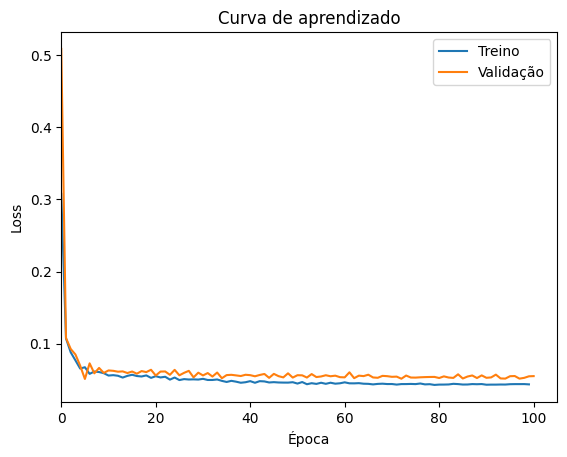

In [18]:
figura, eixo = plt.subplots()

ca_treino = mlp.curva_aprendizado_treino
ca_val = mlp.curva_aprendizado_val

eixo.plot(ca_treino, label="Treino")
eixo.plot(ca_val, label="Validação")

eixo.legend()

eixo.set_xlim(left=0)

eixo.set_title("Curva de aprendizado")
eixo.set_xlabel("Época")
eixo.set_ylabel("Loss");

Vemos que 100 épocas é um valor bem exagerado, nossa rede convergiu bem mais rápido. Treinar por muitas épocas pode fazer com que haja sobreajuste.
Para visualizar melhor, vamos olhar para o conjunto de dados real e para os valores previstos.

In [20]:
import csv

# Arrays de exemplo
array1 = y_true
array2 = y_pred

# Nome do arquivo CSV
filename = 'output.csv'

# Criar e escrever no arquivo CSV
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Escrever cabeçalhos (opcional)
    writer.writerow(['Real', 'Previsto'])
    
    # Escrever os dados
    for a1, a2 in zip(array1, array2):
        writer.writerow([a1, a2])

mostra = pd.read_csv('output.csv')
mostra

,Real,Previsto
0,[0.563],[0.38353236]
1,[0.60899998],[0.38357961]
2,[0.60899998],[0.38307156]
3,[0.56999998],[0.38259172]
4,[0.606],[0.38346236]
5,[0.50300001],[0.38287529]
6,[0.53899999],[0.38349874]
7,[0.58500001],[0.38342082]
8,[0.62699999],[0.38275104]
9,[0.561],[0.38302944]


O que vemos é que nossa rede está prevendo valores muito parecidos, que mudam apenas com muitas casas decimais. Isso quer dizer que o conjunto de hiperparâmetros que definimos não é bom e essa arquitetura não é capaz de captar a complexidade dos nossos dados. Precisamos otimizar esses hiperparâmetros para então explorar a capacidade de uma MLP para resolver o nosso problema.